In [1]:
import matplotlib.pyplot as plt
%matplotlib inline  
%load_ext autoreload
%autoreload 2
import numpy as np
import time
import random
def print_np(x):
    print ("Type is %s" % (type(x)))
    print ("Shape is %s" % (x.shape,))
#     print ("Values are: \n%s" % (x))

In [2]:
import os
import sys
sys.path.append('../')

In [3]:
from model import UnicycleModel
from cost import FinaltimeFreeCost, UnicycleCost
from constraints import UnicycleConstraints
from PTR_tf_free import PTR_tf_free
from PTR_in_MPC import PTR_in_MPC
from Scaling import TrajectoryScaling

from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp

(CVXPY) Feb 10 11:41:25 AM: Encountered unexpected exception importing solver SCS:
ImportError("dlopen(/opt/anaconda3/envs/py309/lib/python3.9/site-packages/_scs_direct.cpython-39-darwin.so, 0x0002): Library not loaded: @rpath/liblapack.3.dylib\n  Referenced from: /opt/anaconda3/envs/py309/lib/python3.9/site-packages/_scs_direct.cpython-39-darwin.so\n  Reason: tried: '/opt/anaconda3/envs/py309/lib/python3.9/site-packages/../../liblapack.3.dylib' (no such file), '/opt/anaconda3/envs/py309/lib/python3.9/site-packages/../../liblapack.3.dylib' (no such file), '/opt/anaconda3/envs/py309/bin/../lib/liblapack.3.dylib' (no such file), '/opt/anaconda3/envs/py309/bin/../lib/liblapack.3.dylib' (no such file), '/usr/local/lib/liblapack.3.dylib' (no such file), '/usr/lib/liblapack.3.dylib' (no such file)")


## Nominal trajectory generation

In [4]:
ix = 3
iu = 2
ih = 2
N = 50
tf = 10
delT = tf/N
max_iter = 30

In [5]:
myModel = UnicycleModel.unicycle2('Hello',ix,iu,'analytic')
myCost = FinaltimeFreeCost.Finaltime('Hello',ix,iu,N)
myConst = UnicycleConstraints.UnicycleConstraints('Hello',ix,iu,[],[])

### nominal trajectory is given as xbar, ubar

In [6]:
horizon = 0.1
dt = 0.1
Nmpc =  int(horizon / dt) # N+1 is total discretization points for state
print("Nmpc: {:}".format(Nmpc))

xi_mpc = np.zeros(3)
xi_mpc[0] = -5.0
xi_mpc[1] = -5.0 
xi_mpc[2] = 0

Nmpc: 1


In [7]:
# cost and constraint / model is identical
MPC_model = UnicycleModel.unicycle2('Hello',ix,iu,'analytic')
MPC_Cost = UnicycleCost.UnicycleMPCCost('Hello',ix,iu,Nmpc)
MPC_Const = UnicycleConstraints.UnicycleMPCConstraints('Hello',ix,iu,num_obs=1)
x_max = np.array([5,5,np.deg2rad(90)])
x_min = np.zeros(ix)

u_max = np.array([2,np.deg2rad(90)]) 
u_min = np.array([0,0])


myScaling = TrajectoryScaling(x_min,x_max,u_min,u_max,tf)
# # define optimal control
MPC_controller = PTR_in_MPC('unicycle',Nmpc,horizon,max_iter,myModel,MPC_Cost,MPC_Const,myScaling,
          type_discretization="zoh",w_c=1,w_vc=1e3,w_tr=1e-1,
                            tol_vc=1e-6,tol_tr=1e-3,verbosity=False)

Is DPP?  True


In [8]:
# nominal trajectory
xmpc,umpc,xprop = np.zeros((Nmpc+1,ix)),np.zeros((Nmpc+1,iu)),np.zeros((Nmpc+1,ix))

In [9]:
# funnel initialization
from utils.utils_alg import get_neighbor_vec,get_K_discrete
from funlopt import funlopt,funlopt_at_final
from Lipschitz import Lipschitz
iw,iq,ip = MPC_model.iw,MPC_model.iq,MPC_model.ip
C,D,E,G = MPC_model.C,MPC_model.D,MPC_model.E,MPC_model.G

Qini = np.diag([0.4**2,0.4**2,np.deg2rad(20)**2])
# Qini = np.diag([0.2**2,0.2**2,np.deg2rad(10)**2])

Qhat = np.tile(np.diag([0.2**2,0.2**2,np.deg2rad(10)**2]),(Nmpc+1,1,1))*0.1
A,B,s,z,x_prop_n = myModel.diff_discrete_zoh(xmpc,umpc,dt,horizon) 
Khat = get_K_discrete(A,B,np.eye(ix),np.eye(iu),np.eye(ix),Nmpc,ix,iu)
Yhat = Khat@Qhat[:Nmpc]

funl_solver = funlopt(ix,iu,iq,ip,iw,Nmpc,myScaling,
                      alpha=0.99,
                      lambda_mu=0.1,
                      w_tr=0,
                      flag_nonlinearity=False)
funl_solver.cvx_initialize(Qini,flag_time_varying=True)

funl_final = funlopt_at_final(ix,iu,iq,ip,iw,Nmpc,myScaling,
                      alpha=0.99,
                      lambda_mu=0.1,
                      w_tr=0,
                      flag_nonlinearity=False)

funl_final.cvx_initialize(Qini)

lip_estimator = Lipschitz(ix,iu,iq,ip,iw,Nmpc,num_sample=100,flag_uniform=True)

linear funnel
Is DPP?  True
linear funnel
Is DPP?  True


In [29]:
# discretization
A,B,F,s,z,_ = MPC_model.diff_discrete_zoh_noise(xmpc,umpc,np.zeros((Nmpc,iw)),dt,horizon) 
# estimiate Lipschitz
lip_estimator.initialize(xmpc,umpc,xprop,Qhat,Khat,A,B,C,D,E,F,G,MPC_model)
gamma = lip_estimator.update_lipschitz_norm(MPC_model,dt)
B[:,1,0] = 0.02
# funnel synthesis
Qmpc,Kmpc,Ympc,status,funl_cost = funl_solver.solve(gamma,Qhat,Yhat,A,B,C,D,E,F,G)


In [30]:
# Qmpc,Kmpc,Ympc,status,funl_cost = funl_final.solve(gamma[0],A[0],B[0],C,D,E,F[0],G)

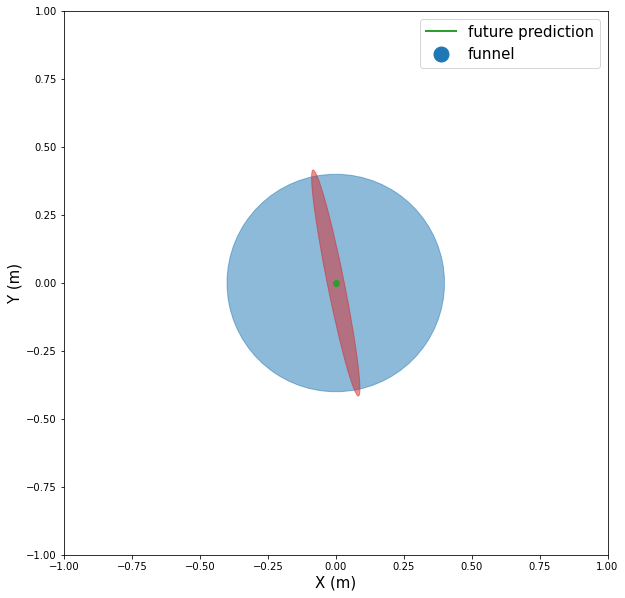

In [31]:
from matplotlib.patches import Rectangle,Ellipse
from utils.utils_plot import plot_funnel
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
fS = 15

plt.plot(xmpc[:,0], xmpc[:,1],'-',color='tab:green', linewidth=2.0,label='future prediction')
plt.plot(xmpc[0,0], xmpc[0,1],'o',color='tab:green', linewidth=2.0)
# plot_funnel(xmpc[0:1],Qmpc[0:1],ax)
plot_funnel(xmpc,Qmpc,ax)

plt.gca().set_aspect('equal', adjustable='box')
plt.axis([-1, 1, -1, 1])
plt.xlabel('X (m)', fontsize = fS)
plt.ylabel('Y (m)', fontsize = fS)
plt.legend(fontsize=fS)


# check the dynamics

In [ ]:
from utils.utils_alg import forward_full_with_K,get_sample_trajectory
import scipy
x0_sample = []
num_sample = 10
for i in range(num_sample) :
    z = np.random.randn(ix)
    z = z / np.linalg.norm(z)
    x_s = xmpc[0] + scipy.linalg.sqrtm(Qmpc[0])@z
    x0_sample.append(x_s)

In [ ]:
tsam,xsam,usam,wsam,xsamp = get_sample_trajectory(xi_mpc,x0_sample,
    xmpc,umpc,Qmpc,Ympc,myModel,Nmpc,
    ix,iu,iw,
    dt,
    flag_noise=True)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
fS = 15
plt.plot(xmpc[:,0], xmpc[:,1],'-',color='tab:green', linewidth=2.0,label='future prediction')
plt.plot(xmpc[0,0], xmpc[0,1],'o',color='tab:green', linewidth=2.0)
# plot_funnel(xmpc[0:1],Qmpc[0:1],ax)
plot_funnel(xmpc,Qmpc,ax)
for i in range(num_sample) :
    xsam_e = xsam[i]
    plt.plot(xsam_e[0,0], xsam_e[0,1],'o',color='tab:purple',linewidth=1.0)
    plt.plot(xsam_e[:,0], xsam_e[:,1],'-',color='tab:purple',linewidth=2.0)

plt.gca().set_aspect('equal', adjustable='box')
# plt.axis([-6, 6, -6, 6])
# plt.axis([-6, 0, -6, 0])
# plt.axis([-3, 3, -3, 3])
plt.axis([-1, 1, -1, 1])
plt.xlabel('X (m)', fontsize = fS)
plt.ylabel('Y (m)', fontsize = fS)
plt.legend(fontsize=fS)
